# import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import os
import json
import math
import shutil
import datetime
from tqdm import tqdm_notebook

from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, Conv1D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import class_weight

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
# define folder path
path = '/content/drive/My Drive/Hatefulle Ytringer Models/'

In [ ]:
# Read datafile
Text_df = pd.read_csv(path+'models/Models 04_10_2021/all_data_used_04_10_2021_revised.csv', sep=',', usecols=['text', 'classification']  ,encoding = "UTF-8")
Text_df

,text,classification
0,det som er trist er å finne på begreper som sn...,1
1,så sier mannen som for noen måneder siden utta...,1
2,frps sterkeste kort i valgkampen 2011,1
3,"ang snikislamisering: dette var, så vidt jeg v...",1
4,awais aslam: nok en gang bruker og forsvarer l...,1
...,...,...
3272,@aft_meninger Utenom i alle muslimske land i h...,1
3273,"@Aftenposten Ja, vi trenger helt klart mer ter...",0
3274,@aft_meninger @jasnoen @tetzschner Altfor mang...,1
3275,@vgnett hvorfor ikke betale privatpersoner for...,1


# check data records

In [ ]:
# number of records belongs to each class
Text_df['classification'].value_counts()

1    2471
0     806
Name: classification, dtype: int64

# Define function to perform preprocessing of data

In [ ]:
def process_tweet(df):
    '''
    Input: 
        df: a dataframe containing a column 'text' of strings of tweets
    Output:
        df with a column 'tweets_clean'
    
    '''
    #remove URL
    df['tweet_proc'] = df['text'].str.replace(r'http(\S)+', r'')
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'http ...', r'')
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'http', r'')
    df[df['tweet_proc'].str.contains(r'http')]

    # remove RT, @
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'(RT|rt)[ ]*@[ ]*[\S]+',r'')
    df[df['tweet_proc'].str.contains(r'RT[ ]?@')]
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'@[\S]+',r'')

    #remove &, < og >
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'&amp;?',r'og')
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'&lt;',r'<')
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'&gt;',r'>')

    # remove extra space
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'[ ]{2, }',r' ')

    # insert space between punctuation marks
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
    df['tweet_proc'] = df['tweet_proc'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')

    # lower case and strip white spaces at both ends
    df['tweet_proc'] = df['tweet_proc'].str.lower()
    df['tweet_proc'] = df['tweet_proc'].str.strip()

    return df

In [ ]:
# clean text
Text_df = process_tweet(Text_df)
Text_df

,text,classification,tweet_proc
0,det som er trist er å finne på begreper som sn...,1,det som er trist er å finne på begreper som sn...
1,så sier mannen som for noen måneder siden utta...,1,så sier mannen som for noen måneder siden utta...
2,frps sterkeste kort i valgkampen 2011,1,frps sterkeste kort i valgkampen 2011
3,"ang snikislamisering: dette var, så vidt jeg v...",1,"ang snikislamisering : dette var , så vidt jeg..."
4,awais aslam: nok en gang bruker og forsvarer l...,1,awais aslam : nok en gang bruker og forsvarer ...
...,...,...,...
3272,@aft_meninger Utenom i alle muslimske land i h...,1,utenom i alle muslimske land i hele verden .
3273,"@Aftenposten Ja, vi trenger helt klart mer ter...",0,"ja , vi trenger helt klart mer terror . not !!..."
3274,@aft_meninger @jasnoen @tetzschner Altfor mang...,1,altfor mange politikere inkludert stortingspol...
3275,@vgnett hvorfor ikke betale privatpersoner for...,1,hvorfor ikke betale privatpersoner for å gi hu...


# check the most common words and least popular words

In [ ]:
data = Counter(''.join(Text_df['tweet_proc'].values).split())

print('Most occurance word: \n\n', data.most_common()[:10])
print('\n\nLeast occurance word: \n\n', data.most_common()[-10:])

Most occurance word: 

 [('.', 3112), (',', 2768), ('er', 2700), ('og', 2271), ('i', 2000), ('det', 1901), ('som', 1720), ('å', 1460), ('ikke', 1393), ('en', 1125)]


Least occurance word: 

 [('dulle', 1), ('!altfor', 1), ('stortingspolitikere', 1), ('argumentert', 1), ('privatpersoner', 1), ('husly', 1), ('aktivisert', 1), ('alt....', 1), ('positv', 1), ('banditt', 1)]


We can oberve that the dataset contains a lots of non-alphabetic words. These words does not add value in the model. 

# check number of words with single occurance

In [ ]:
count=0
for word, num in data.items():
  if num==1:
    count+=1
print('{} number of words occur only one time'.format(count))

9189 number of words occur only one time


# clean text more

In [ ]:
# convert smile emoji to smile word
Text_df['tweet_proc'] = Text_df['tweet_proc'].str.replace(':-\)', 'smile')

# convert sad emoji to sad word
Text_df['tweet_proc'] = Text_df['tweet_proc'].str.replace(':-\(', 'trist')

# remove all non-alphabetic characters
Text_df['tweet_proc'] = Text_df['tweet_proc'].str.replace(r'[^a-zåøæ ]', '')

# remove stop words

In [ ]:
stop_words = stopwords.words('norwegian')
stop_words.remove('ikke')
stop_words.remove('ikkje')

Text_df['tweet_proc'] = Text_df['tweet_proc'].apply(lambda x:' '.join(w for w in x.split() if w not in stop_words))

# remove tweets which are less than or equal to three words 

In [ ]:
Text_df = Text_df[Text_df.tweet_proc.apply(lambda x: len(x.split())>3)]
Text_df

,text,classification,tweet_proc
0,det som er trist er å finne på begreper som sn...,1,trist finne begreper snikislamisering styre de...
1,så sier mannen som for noen måneder siden utta...,1,sier mannen måneder uttalte innføre sharialån ...
2,frps sterkeste kort i valgkampen 2011,1,frps sterkeste kort valgkampen
3,"ang snikislamisering: dette var, så vidt jeg v...",1,ang snikislamisering vidt vet ord siv jensen i...
4,awais aslam: nok en gang bruker og forsvarer l...,1,awais aslam nok gang bruker forsvarer landets ...
...,...,...,...
3272,@aft_meninger Utenom i alle muslimske land i h...,1,utenom muslimske land hele verden
3273,"@Aftenposten Ja, vi trenger helt klart mer ter...",0,trenger helt klart mer terror not må norge ves...
3274,@aft_meninger @jasnoen @tetzschner Altfor mang...,1,altfor politikere inkludert stortingspolitiker...
3275,@vgnett hvorfor ikke betale privatpersoner for...,1,ikke betale privatpersoner gi husly samtidig m...


# count total of vocabulary (words) 

In [ ]:
vocab_length = len(Counter(' '.join(Text_df['tweet_proc'].values).split()))
vocab_length

11851

# convert vocab into tokenizer and sequences

In [ ]:
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(Text_df['tweet_proc'].values)

X = tokenizer.texts_to_sequences(Text_df['tweet_proc'].values)
X = pad_sequences(X, maxlen=128, padding='post', truncating='post')
Y = Text_df['classification']

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print('vocab_size: ', vocab_size)

vocab_size:  11852


# save tokanizer for classifying new tweets

In [ ]:
import io
tokenizer_json_2 = tokenizer.to_json()
base = '/content/drive/My Drive/Hatefulle Ytringer Models/models/Models 16_10_2021/'
with io.open(base + 'tokenizer.json_16102021_v1', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json_2, ensure_ascii=False))

# split the data into train and test size

In [ ]:
X_train, X2, y_train, y2 = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, stratify=y2)

# replace 99 () as 1

In [ ]:
y_train = y_train.replace(99, 1)
y_val = y_val.replace(99, 1)
y_test = y_test.replace(99, 1)

# number of records used in train, test and validation

In [ ]:
print(f'Train data shape {X_train.shape}, {y_train.shape}, {Counter(y_train)}')
print(f'Validation data shape {X_val.shape}, {y_val.shape}, {Counter(y_val)}')
print(f'Test data shape {X_test.shape}, {y_test.shape}, {Counter(y_test)}')

Train data shape (2293, 128), (2293,), Counter({1: 1729, 0: 564})
Validation data shape (492, 128), (492,), Counter({1: 371, 0: 121})
Test data shape (492, 128), (492,), Counter({1: 371, 0: 121})


# Build Artificial Neural Network (ANN) model

In [ ]:
def create_ann_model():
  model = Sequential()
  model.add(Embedding(vocab_size, 28))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_ann_model_2():
  model = Sequential()
  model.add(Embedding(vocab_size, 32))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

# define checkpoint to store model when it yields highest accuracy

In [ ]:
# create current folder to store current model
dt = datetime.datetime.now()
dt = str(dt).replace(' ', '_')[:-7]

if not os.path.exists(path+'models/'+f'model_{dt}'):
  os.mkdir(path+'models/'+f'model_{dt}')
else:
  for m in os.listdir(path+'models/'+f'model_{dt}/'):
    os.remove(path+'models/'+f'model_{dt}/'+m)

checkpoint_filepath = path+f'models/model_{dt}/'+'ANN-{epoch:02d}-{val_accuracy:.4f}.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# create model
ann = create_ann_model()
# ann = create_ann_model_2()

# train and predict with default model
ann.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, verbose=0, batch_size=10, callbacks=[model_checkpoint_callback])
_, acc = ann.evaluate(X_test, y_test)
print('Test accuracy of default model: ', acc)

# findout best model path from saved folder 
acc = 0
best_model = None
for mpath in os.listdir(path+f'models/model_{dt}/'):
  val = float(mpath.split('-')[-1].replace('.hdf5',''))
  if val>acc:
    best_model = mpath

# load the best model
checkpoint_filepath = path+f'models/model_{dt}/'+best_model
ann.load_weights(checkpoint_filepath)

# predict with best model
yhat_prob = ann.predict(X_test)
_, acc = ann.evaluate(X_test, y_test)
print('Test accuracy of saved model: ', acc)

16/16 [==============================] - 0s 2ms/step - loss: 0.8247 - accuracy: 0.7866
Test accuracy of default model:  0.7865853905677795
16/16 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.8150
Test accuracy of saved model:  0.815040647983551


# convert probability into classification based on threshold

In [ ]:
yhat = [1 if y>0.5 else 0 for y in yhat_prob]

# create function to print the different metrics

In [ ]:
def print_metrics(real, predict):
  print('Accuracy: ', accuracy_score(real, predict))
  print('\nPrecision: ', precision_score(real, predict))
  print('\nrecall: ', recall_score(real, predict))
  print('\nf1_score: ', f1_score(real, predict))
  print('\nconfusion_matrix:\n ', pd.DataFrame(confusion_matrix(real, predict), index=[0, 1], columns=[0, 1]))
  print('\nclassification_report:\n ', classification_report(real, predict))

In [ ]:
print_metrics(y_test, yhat)

Accuracy:  0.8150406504065041

Precision:  0.8535353535353535

recall:  0.9110512129380054

f1_score:  0.8813559322033897

confusion_matrix:
      0    1
0  63   58
1  33  338

classification_report:
                precision    recall  f1-score   support

           0       0.66      0.52      0.58       121
           1       0.85      0.91      0.88       371

    accuracy                           0.82       492
   macro avg       0.75      0.72      0.73       492
weighted avg       0.81      0.82      0.81       492



# AUC ROC curve
<br>

True Positive Rate = True Positives / (True Positives + False Negatives)

False Positive Rate = False Positives / (False Positives + True Negatives)

ROC_AUC Score:  0.8296540509233477
Optimal threshold value is: 0.7773687


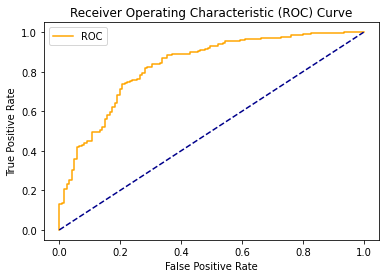

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_score = np.array(yhat_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('ROC_AUC Score: ', roc_auc_score(y_test, y_score))

# find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

# model accuracy based on optimal threshold


In [ ]:
yhat = [1 if y>optimal_threshold else 0 for y in yhat_prob]
print_metrics(y_test, yhat)

Accuracy:  0.7926829268292683

Precision:  0.8991097922848664

recall:  0.816711590296496

f1_score:  0.8559322033898304

confusion_matrix:
      0    1
0  87   34
1  68  303

classification_report:
                precision    recall  f1-score   support

           0       0.56      0.72      0.63       121
           1       0.90      0.82      0.86       371

    accuracy                           0.79       492
   macro avg       0.73      0.77      0.74       492
weighted avg       0.82      0.79      0.80       492



In [ ]:
# save model
ann.save(path+f'models/model/')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Hatefulle Ytringer Models/models/model/assets
